# TODO:
 1. Create (small) Dataset for comparison of different data imputation techniques
 2. Run several imputation methods
 3. Compare them in time and accuracy
 4. Write first chapter of thesis!

Imputation techniques:
* mean / median
* k-NN
* MICE
* Maybe some additional methods at a later point


In [1]:
import sys
import os
import time

import numpy as np
import pandas as pd
import missingno as msno
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

#from sklearn.experimental import enable_iterative_imputer   #line needed because something is deprecated
from sklearn import linear_model

from IPython.core.display_functions import display

#from NDBC_Buoy_Data import myLibrary as mL
dir_root =os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))
sys.path.append(dir_root)
import myLibrary as mL

NDBC = mL.NDBC_lib

----

# Build Dataset

Find station and year with lowest num of NaN values!

In [5]:
stations = NDBC.stations_GOM
years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020" "2021", "2022"]

NaN_statistic = pd.DataFrame()
for year in years:
    for stationID in NDBC.cleaned_stations_GOM:
        data = NDBC.get_data_file(stationID, year)
        if data is not None:
            data = NDBC.df_modification(data)[1]
            data = NDBC.replace_with_NaN(data)
            num_values, num_NaN_percentage, NaN_by_feature = NDBC.print_NaN_statistic(data, "", silent=True)

            new_row = pd.DataFrame({
                    "StationID": [stationID],
                    "Year": [year],
                    "#NaN in %": [num_NaN_percentage]
                })
            NaN_statistic = pd.concat([NaN_statistic, new_row])

Failed to get file: HTTP Error 404: Not Found
from web
from web
from web
from web
from web
from web
from web
Failed to get file: HTTP Error 404: Not Found
from web
Failed to get file: HTTP Error 404: Not Found
from web
from web
from web
from web
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
from web
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to

In [6]:
NaN_statistic

,StationID,Year,#NaN in %
0,41112,2010,61.86
0,42001,2010,54.82
0,42002,2010,39.09
0,42012,2010,17.21
0,42013,2010,81.65
...,...,...,...
0,42055,2022,56.78
0,42095,2022,55.18
0,42097,2022,62.14
0,42098,2022,63.14


As we can see, the dataset of station 42001 of the year 2016 includes the lowest amount of NaN values, so lets continue with that file.

In [2]:
test_data = NDBC.get_data_file("42001", "2016")
test_data = NDBC.df_modification(test_data)[1]
test_data = NDBC.replace_with_NaN(test_data)
test_data

from disc


,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001,VIS_42001,TIDE_42001
timestamp,,,,,,,,,,,,,
2016-03-30 09:50:00,115,9.2,10.8,1.19,5.00,3.98,93,1013.2,24.3,23.9,23.2,NaN,NaN
2016-03-30 10:50:00,114,7.1,8.5,1.17,5.56,4.47,95,1013.5,24.4,23.9,23.2,NaN,NaN
2016-03-30 11:50:00,116,7.8,9.0,1.20,5.56,4.48,102,1013.7,24.4,23.9,23.0,NaN,NaN
2016-03-30 12:50:00,116,7.4,8.5,1.24,6.25,4.56,94,1014.4,24.5,23.9,23.1,NaN,NaN
2016-03-30 13:50:00,118,7.7,9.0,1.28,5.88,4.73,95,1014.9,24.7,23.9,23.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 18:50:00,166,9.2,11.3,1.52,6.67,4.81,76,1016.2,24.2,24.7,18.9,NaN,NaN
2016-12-31 19:50:00,155,9.3,11.1,1.68,5.56,4.93,138,1014.9,24.3,24.7,19.0,NaN,NaN
2016-12-31 20:50:00,161,9.2,10.5,1.58,6.25,4.90,100,1014.4,24.5,24.8,19.5,NaN,NaN


<AxesSubplot:>

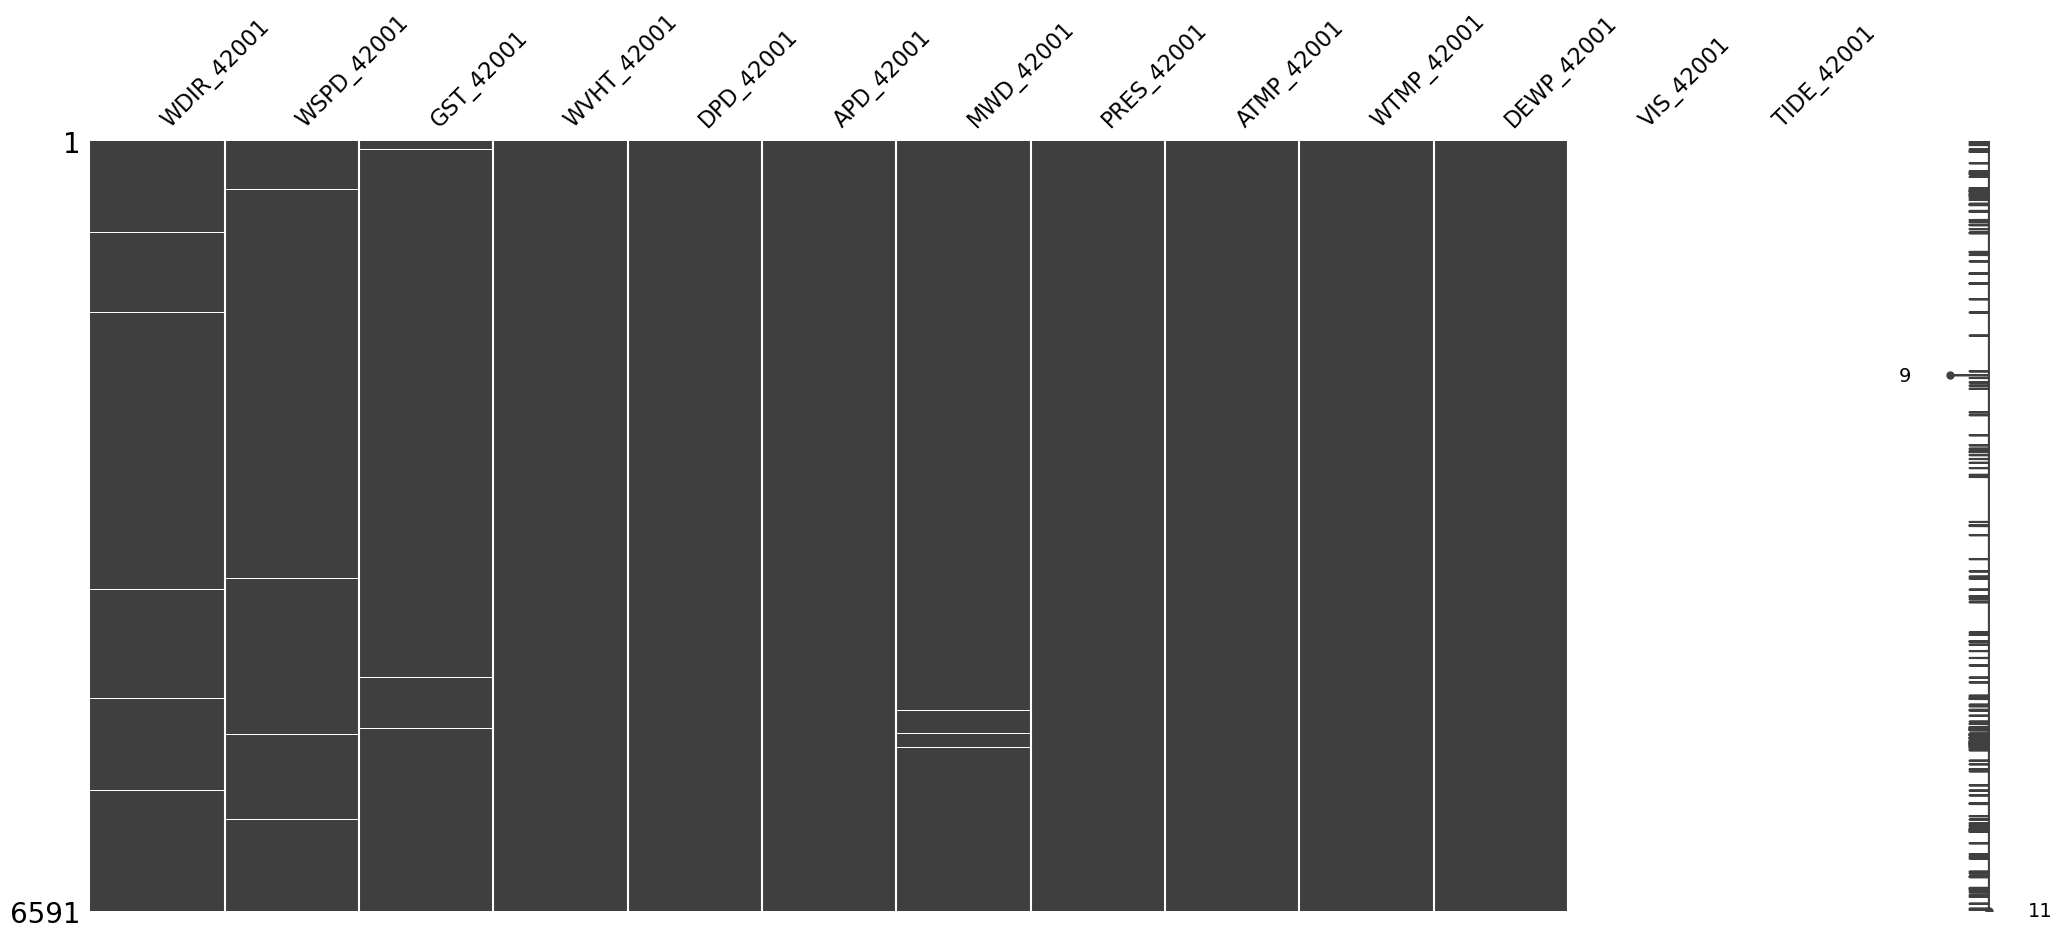

In [3]:
msno.matrix(test_data)

The graph shows that the features VIS and TIDE do not provide any values, so lets those colums without any values!

In [4]:
#test_data = NDBC.drop_NaN_rows_and_cols(test_data) #ORIGINAL!
test_data = test_data.dropna(axis=1, how='all')  # drop cols if all values are NaN  #ATTENTION: CODE CHANGED WITHOUT EXECUTION!!!!
test_data = test_data.drop(["GST_42001", "DPD_42001"], axis=1) #Drop columns not considered in my study
test_data.head()

,WDIR_42001,WSPD_42001,WVHT_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
timestamp,,,,,,,,,
2016-03-30 09:50:00,115,9.2,1.19,3.98,93,1013.2,24.3,23.9,23.2
2016-03-30 10:50:00,114,7.1,1.17,4.47,95,1013.5,24.4,23.9,23.2
2016-03-30 11:50:00,116,7.8,1.20,4.48,102,1013.7,24.4,23.9,23.0
2016-03-30 12:50:00,116,7.4,1.24,4.56,94,1014.4,24.5,23.9,23.1
2016-03-30 13:50:00,118,7.7,1.28,4.73,95,1014.9,24.7,23.9,23.0


In [5]:
num_values, num_NaN_percentage, NaN_by_feature = NDBC.print_NaN_statistic(test_data, "") #unneeded


 
number of values:  59319
number of NaN values:  137 ( 0.23 %)



In [6]:
NaN_by_feature

,Feature,#NaN,%NaN
0,WDIR_42001,49,0.74
1,WSPD_42001,22,0.33
2,WVHT_42001,0,0.00
3,APD_42001,0,0.00
4,MWD_42001,66,1.00
5,PRES_42001,0,0.00
6,ATMP_42001,0,0.00
7,WTMP_42001,0,0.00
8,DEWP_42001,0,0.00


We do still have some NaN values ... now we delete those rows!

In [7]:
test_data = test_data.dropna(axis=0, how="any")  # drop rows if any values is NaN
test_data

,WDIR_42001,WSPD_42001,WVHT_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
timestamp,,,,,,,,,
2016-03-30 09:50:00,115,9.2,1.19,3.98,93,1013.2,24.3,23.9,23.2
2016-03-30 10:50:00,114,7.1,1.17,4.47,95,1013.5,24.4,23.9,23.2
2016-03-30 11:50:00,116,7.8,1.20,4.48,102,1013.7,24.4,23.9,23.0
2016-03-30 12:50:00,116,7.4,1.24,4.56,94,1014.4,24.5,23.9,23.1
2016-03-30 13:50:00,118,7.7,1.28,4.73,95,1014.9,24.7,23.9,23.0
...,...,...,...,...,...,...,...,...,...
2016-12-31 18:50:00,166,9.2,1.52,4.81,76,1016.2,24.2,24.7,18.9
2016-12-31 19:50:00,155,9.3,1.68,4.93,138,1014.9,24.3,24.7,19.0
2016-12-31 20:50:00,161,9.2,1.58,4.90,100,1014.4,24.5,24.8,19.5


In [8]:
NDBC.print_NaN_statistic(test_data, "Are all NaN values removed?")


 Are all NaN values removed?
number of values:  58095
number of NaN values:  0 ( 0.0 %)



(58095,
 0.0,
       Feature  #NaN  %NaN
 0  WDIR_42001     0   0.0
 1  WSPD_42001     0   0.0
 2  WVHT_42001     0   0.0
 3   APD_42001     0   0.0
 4   MWD_42001     0   0.0
 5  PRES_42001     0   0.0
 6  ATMP_42001     0   0.0
 7  WTMP_42001     0   0.0
 8  DEWP_42001     0   0.0)

--> All NaN values have successfully been removed. That means a "ground truth" dataset has successfully been created!

In [9]:
test_data.to_pickle("../data/NaN_ground_truth.pickle")

---

# Prepare evaluation
- exchange x% of the values at a random positon with NaN

In [10]:
test_data = pd.read_pickle("../data/NaN_ground_truth.pickle").astype(float)

In [11]:
test_data

,WDIR_42001,WSPD_42001,WVHT_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
timestamp,,,,,,,,,
2016-03-30 09:50:00,115.0,9.2,1.19,3.98,93.0,1013.2,24.3,23.9,23.2
2016-03-30 10:50:00,114.0,7.1,1.17,4.47,95.0,1013.5,24.4,23.9,23.2
2016-03-30 11:50:00,116.0,7.8,1.20,4.48,102.0,1013.7,24.4,23.9,23.0
2016-03-30 12:50:00,116.0,7.4,1.24,4.56,94.0,1014.4,24.5,23.9,23.1
2016-03-30 13:50:00,118.0,7.7,1.28,4.73,95.0,1014.9,24.7,23.9,23.0
...,...,...,...,...,...,...,...,...,...
2016-12-31 18:50:00,166.0,9.2,1.52,4.81,76.0,1016.2,24.2,24.7,18.9
2016-12-31 19:50:00,155.0,9.3,1.68,4.93,138.0,1014.9,24.3,24.7,19.0
2016-12-31 20:50:00,161.0,9.2,1.58,4.90,100.0,1014.4,24.5,24.8,19.5


In [12]:
NDBC.print_NaN_statistic(test_data, "Are all NaN values removed?")


 Are all NaN values removed?
number of values:  58095
number of NaN values:  0 ( 0.0 %)



(58095,
 0.0,
       Feature  #NaN  %NaN
 0  WDIR_42001     0   0.0
 1  WSPD_42001     0   0.0
 2  WVHT_42001     0   0.0
 3   APD_42001     0   0.0
 4   MWD_42001     0   0.0
 5  PRES_42001     0   0.0
 6  ATMP_42001     0   0.0
 7  WTMP_42001     0   0.0
 8  DEWP_42001     0   0.0)

# Data normalization

In [13]:
scaler = MinMaxScaler()
test_data = pd.DataFrame(scaler.fit_transform(test_data), columns = test_data.columns)
test_data.head()

,WDIR_42001,WSPD_42001,WVHT_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
0,0.317549,0.621622,0.268571,0.192771,0.256267,0.376068,0.386555,0.055556,0.73125
1,0.314763,0.479730,0.262857,0.291165,0.261838,0.388889,0.394958,0.055556,0.73125
2,0.320334,0.527027,0.271429,0.293173,0.281337,0.397436,0.394958,0.055556,0.71875
3,0.320334,0.500000,0.282857,0.309237,0.259053,0.427350,0.403361,0.055556,0.72500
4,0.325905,0.520270,0.294286,0.343373,0.261838,0.448718,0.420168,0.055556,0.71875


## TODO:

- Evaluate data imputation techniques depending on % of NaN values in the perspective of execution time (clock time or CPU time?) and accuracy
- Also consider executing it on Google Colab for better comparability than using M1 chip!

----
# Data Imputation Techniques:

All functions should take a dataframe with NaN values as input and return a dataframe with the imputed values. Those methods must be useable as a parameter for the evaluation function!

In [14]:
def imputation_fedfroward(data):
    data.fillna(method='ffill', inplace=True)   #replace all NaN values with previous valid value
    data.fillna(method='bfill', inplace=True)   #back-forward ... needed for case that there is no previous value -> takes the following valid value
    return data

In [15]:
def imputation_mean(data):
    return data.fillna(data.mean()) #replace all NaN values with the column-mean

In [16]:
def imputation_median(data):
    return data.fillna(data.median()) #replace all NaN values with the column-median

In [17]:
def imputation_knn(k):
    def imputation(data):
        imputer_knn = KNNImputer(n_neighbors=k, weights='uniform', metric='nan_euclidean')
        return pd.DataFrame(imputer_knn.fit_transform(data),columns = data.columns)
    return imputation

In [18]:
def imputation_mice(data):
    # Define MICE Imputer
    imputer_mice = IterativeImputer(
        estimator=linear_model.BayesianRidge(),
        n_nearest_features=None,
        imputation_order='ascending',
        max_iter=30,
        verbose=0)

    imputer_mice.fit(data)   #fit imputer on the dataset
    imputed_data = pd.DataFrame(imputer_mice.transform(data)) #transform the dataset #What exactly happens here?
    imputed_data.columns=data.columns
    return imputed_data

    #ISSUE: Column name and index got lost!

----
# Evaluation:

As Accuracy I use MSE (=Mean Square Error) since it is also used in the paper about DataWig. I need some arguments why this is correct / figure out if it even is the best way to measure the accuracy.

In [19]:
#This function can be used to evaluate the performance (time and accuracy) of a certain imputation technique on a certain dataset (=dataframe) and a certain NaN_rate
def evaluate(imputation, df_ground_truth, NaN_rate):
    df_NaN = df_ground_truth.mask(np.random.random(df_ground_truth.shape) < NaN_rate)   #NaN rate 10% = .1

    start_time = time.time()

    df_imputated = imputation(df_NaN)

    end_time = time.time()
    exec_time = end_time - start_time

    #Convert dataframes to list (needed to calc. mse)
    gt_list = list()
    imp_list = list()
    for gt_column, imp_column in zip(df_ground_truth, df_imputated):
        gt_list += df_ground_truth[gt_column].tolist()
        imp_list += df_imputated[imp_column].tolist()

    mse = mean_squared_error(gt_list, imp_list, squared=False)
    return mse, exec_time

In [20]:
evaluate(imputation_fedfroward, test_data, NaN_rate=.1)

(0.020140844954411926, 0.0009527206420898438)

In [21]:
evaluate(imputation_mean, test_data, NaN_rate=.1)

(0.057158427950483544, 0.00394892692565918)

In [22]:
evaluate(imputation_knn(5), test_data, NaN_rate=.1)

(0.02458531339103737, 1.1257059574127197)

In [24]:
#TODO:
def multiple_evaluation(imp_function, df_ground_truth):
    NaN_rates = np.arange(0, 1, .05)

    statistic = pd.DataFrame(columns=["%NaN", "MSE", "Exec Time"])
    for NaN_rate in NaN_rates:
        mse, exec_time = evaluate(imp_function, df_ground_truth, NaN_rate)

        #create statistic
        new_row = pd.DataFrame({
                    "%NaN": [NaN_rate],
                    "MSE": [mse],
                    "Exec Time": [exec_time]
                })
        statistic = pd.concat([statistic, new_row])

    return statistic


multiple_evaluation(imputation_mean, test_data)

,%NaN,MSE,Exec Time
0,0.00,0.000000,0.002842
0,0.05,0.041178,0.002510
0,0.10,0.057443,0.001646
0,0.15,0.069913,0.002777
0,0.20,0.081179,0.001760
0,0.25,0.089450,0.001555
0,0.30,0.098627,0.001532
0,0.35,0.107004,0.001557
0,0.40,0.113307,0.002012
0,0.45,0.121887,0.001850


In [34]:
def visualize_evaluation(imputation_techniques):
    imp_tech_names =[]
    mse_statistic = pd.DataFrame()
    time_statistic = pd.DataFrame()

    for imp_technique in imputation_techniques:
        statistic = multiple_evaluation(imp_technique[0], test_data)
        mse_statistic[imp_technique[1]] = statistic["MSE"]
        time_statistic[imp_technique[1]] = statistic["Exec Time"]
        imp_tech_names.append(imp_technique[1])

    mse_statistic.index = statistic["%NaN"]
    time_statistic.index = statistic["%NaN"]

    # visualize
    print("MSE:")
    display(mse_statistic)
    print("Time:")
    display(time_statistic)

    mse_statistic.plot( y=imp_tech_names,
                        ylabel = "MSE",
                        xlabel = "NaN rate",
                    title="Data Imputation MSE",
                )

    #time_statistic.plot( y=imp_tech_names,
    #                title="Data Imputation Execution Time"
    #            )

    time_statistic.plot(title="Data Imputation Execution Time")
    plt.yscale('log')
    plt.show()


    return mse_statistic, time_statistic

# Experiments:

MSE:


,Forward,Mean,Median,k-NN (k=5)
%NaN,,,,
0.00,0.000000,0.000000,0.000000,0.000000
0.05,0.014561,0.042839,0.040833,0.017045
0.10,0.021759,0.056871,0.057339,0.025281
0.15,0.024541,0.068481,0.071031,0.037513
0.20,0.032130,0.079880,0.081205,0.050455
0.25,0.032496,0.089248,0.092303,0.068103
0.30,0.037377,0.098759,0.100252,0.082623
0.35,0.042334,0.106797,0.108631,0.095609
0.40,0.046337,0.113059,0.116956,0.105494


Time:


,Forward,Mean,Median,k-NN (k=5)
%NaN,,,,
0.00,0.000593,0.001084,0.001673,0.001188
0.05,0.000209,0.001480,0.002128,0.700244
0.10,0.000218,0.001482,0.002217,0.802398
0.15,0.000257,0.001494,0.002166,1.029559
0.20,0.000299,0.001513,0.002187,1.303061
0.25,0.000278,0.001496,0.002169,1.876674
0.30,0.000285,0.001411,0.002151,2.226116
0.35,0.000286,0.001368,0.004470,2.100588
0.40,0.000314,0.001385,0.009605,2.537928


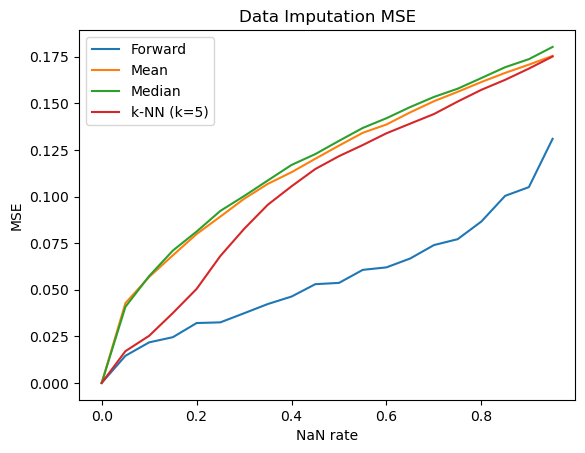

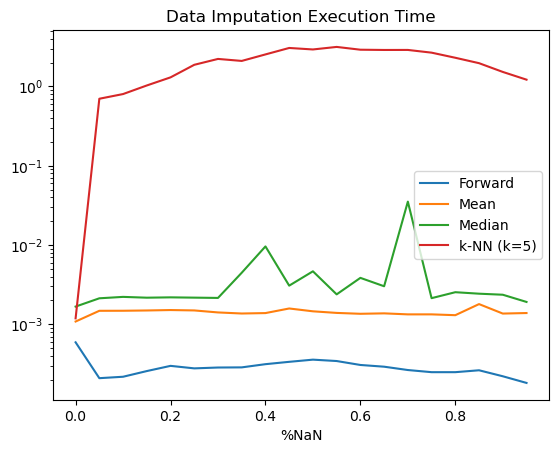

In [35]:
imputation_techniques = [
    (imputation_fedfroward, "Forward"),
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(5), "k-NN (k=5)"),
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

MSE:


,Forward,Mean,Median,k-NN (k=1),k-NN (k=4),k-NN (k=16),k-NN (k=64),k-NN (k=256),k-NN (k=512)
%NaN,,,,,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.05,0.015284,0.040284,0.040678,0.019152,0.016951,0.018469,0.021580,0.024138,0.025979
0.10,0.021082,0.057076,0.058337,0.031405,0.025414,0.028040,0.032048,0.037111,0.039492
0.15,0.027861,0.069717,0.071535,0.053089,0.036777,0.035400,0.042053,0.045965,0.049871
0.20,0.030663,0.079643,0.082589,0.078954,0.054204,0.049514,0.051138,0.055438,0.059319
0.25,0.034616,0.090062,0.091957,0.099290,0.070537,0.060185,0.060043,0.063193,0.067493
0.30,0.038389,0.099137,0.100203,0.116769,0.084178,0.074595,0.072140,0.073535,0.075285
0.35,0.044999,0.106191,0.108375,0.133527,0.097918,0.087284,0.081889,0.082311,0.084280
0.40,0.048950,0.113884,0.116480,0.146498,0.108146,0.096759,0.091590,0.091419,0.092049


Time:


,Forward,Mean,Median,k-NN (k=1),k-NN (k=4),k-NN (k=16),k-NN (k=64),k-NN (k=256),k-NN (k=512)
%NaN,,,,,,,,,
0.00,0.000274,0.000986,0.001595,0.000948,0.001052,0.000943,0.000947,0.000911,0.000942
0.05,0.000192,0.001276,0.002026,0.411366,0.442636,0.412640,0.431850,0.461314,0.460876
0.10,0.000210,0.001954,0.002071,0.751673,0.792192,0.769214,0.784573,0.881734,0.863609
0.15,0.000213,0.001694,0.002105,0.992109,1.072966,1.072970,1.067184,1.217516,1.150432
0.20,0.000258,0.001472,0.002073,1.259912,1.357224,1.335139,1.344239,1.408978,1.505751
0.25,0.000309,0.001332,0.002314,1.745170,1.598411,1.533901,1.579728,1.694366,1.797120
0.30,0.000295,0.001372,0.002137,1.636606,1.788275,1.740231,1.770603,1.965935,1.967059
0.35,0.000318,0.001342,0.002192,2.290808,2.067087,2.096557,2.318990,2.299301,2.288986
0.40,0.000335,0.001434,0.002208,2.432092,2.534642,2.490754,2.507443,2.685892,2.843076


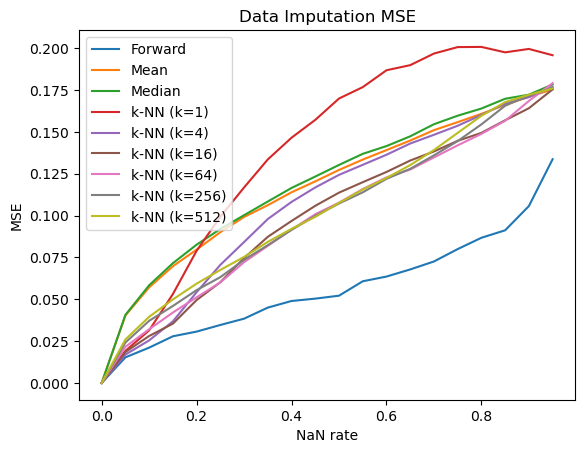

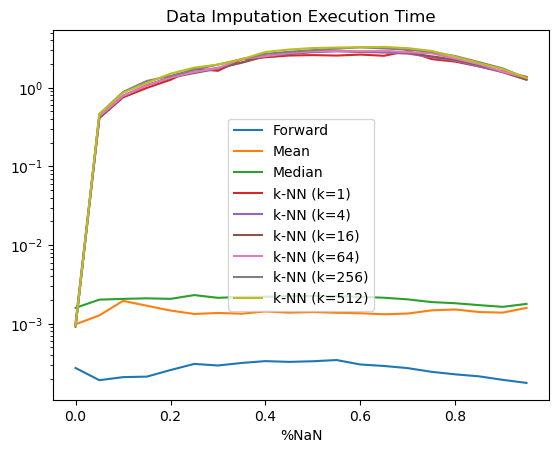

In [36]:
imputation_techniques = [
    (imputation_fedfroward, "Forward"),
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(1), "k-NN (k=1)"),
    #(imputation_knn(2), "k-NN (k=2)"),
    (imputation_knn(4), "k-NN (k=4)"),
    #(imputation_knn(8), "k-NN (k=8)"),
    (imputation_knn(16), "k-NN (k=16)"),
    #(imputation_knn(32), "k-NN (k=32)"),
    (imputation_knn(64), "k-NN (k=64)"),
    #(imputation_knn(128), "k-NN (k=128)"),
    (imputation_knn(256), "k-NN (k=256)"),
    (imputation_knn(512), "k-NN (k=512)")
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

MSE:


,Forward,Mean,Median,k-NN (k=256),k-NN (k=512),k-NN (k=1024),k-NN (k=2028),k-NN (k=4058),k-NN (k=8132)
%NaN,,,,,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.05,0.015652,0.040645,0.041958,0.026214,0.026593,0.026021,0.025583,0.025676,0.026965
0.10,0.021866,0.055555,0.058794,0.038681,0.036687,0.036561,0.036656,0.036234,0.039630
0.15,0.024960,0.068067,0.071519,0.046456,0.046167,0.046964,0.048036,0.047129,0.049788
0.20,0.029243,0.080639,0.081977,0.056440,0.055084,0.056140,0.055171,0.055430,0.059614
0.25,0.034276,0.090114,0.092560,0.064151,0.063840,0.065183,0.064961,0.065350,0.067747
0.30,0.037667,0.098708,0.101534,0.073904,0.073372,0.073322,0.074058,0.072820,0.075346
0.35,0.042959,0.105830,0.108479,0.083359,0.081364,0.083099,0.083587,0.081664,0.084898
0.40,0.046490,0.113865,0.116000,0.091307,0.089333,0.091493,0.092508,0.089365,0.092863


Time:


,Forward,Mean,Median,k-NN (k=256),k-NN (k=512),k-NN (k=1024),k-NN (k=2028),k-NN (k=4058),k-NN (k=8132)
%NaN,,,,,,,,,
0.00,0.000189,0.001175,0.001560,0.000925,0.000925,0.000922,0.000907,0.000911,0.000901
0.05,0.000193,0.001530,0.002016,0.428082,0.441278,0.442988,0.435738,0.426025,0.422248
0.10,0.000206,0.001569,0.002030,0.789933,0.833704,0.803499,0.783351,0.800446,0.844552
0.15,0.000209,0.001422,0.002019,1.070587,1.098122,1.117419,1.110491,1.082290,1.129318
0.20,0.000248,0.001312,0.002020,1.400364,1.407623,1.367196,1.356242,1.361800,1.457057
0.25,0.000274,0.001544,0.002074,1.571298,1.636357,1.634056,1.590832,1.618941,1.683646
0.30,0.000293,0.001422,0.002138,1.758127,1.836355,1.816432,1.812803,1.839134,1.930724
0.35,0.000302,0.001441,0.002142,2.142090,2.119049,2.438886,2.426088,2.165403,2.510565
0.40,0.000347,0.001448,0.002106,2.577953,2.609906,2.652029,2.617857,2.596945,2.781202


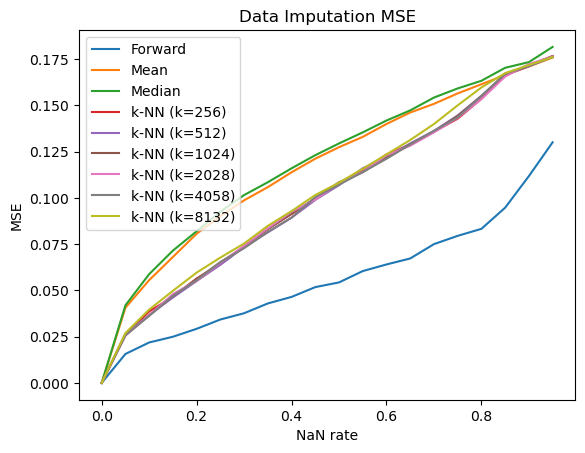

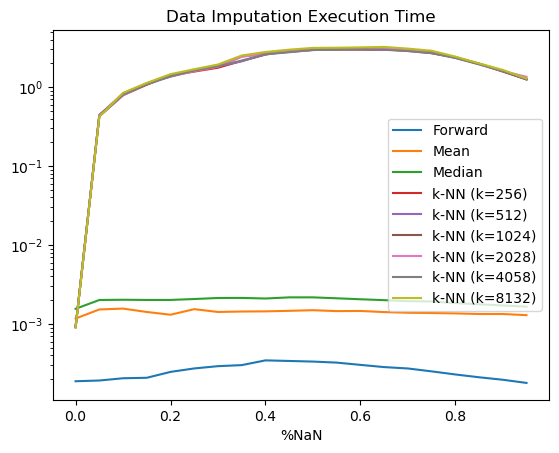

In [37]:
imputation_techniques = [
    (imputation_fedfroward, "Forward"),
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(256), "k-NN (k=256)"),
    (imputation_knn(256), "k-NN (k=512)"),
    (imputation_knn(256), "k-NN (k=1024)"),
    (imputation_knn(256), "k-NN (k=2028)"),
    (imputation_knn(256), "k-NN (k=4058)"),
    (imputation_knn(512), "k-NN (k=8132)")
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

K-NN with k=4 and k=16 result in the lowest MSE for a dataset with less than 50% missing data! If time matters, simply using the mean is definitely the best choice!

/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [Ite

MSE:


,Forward,Mean,Median,k-NN (k=16),MICE
%NaN,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000
0.05,0.014054,0.039567,0.041225,0.019237,0.025718
0.10,0.020759,0.056643,0.058134,0.028229,0.036266
0.15,0.024595,0.069836,0.071557,0.038208,0.045872
0.20,0.028996,0.080289,0.082108,0.047690,0.054936
0.25,0.035935,0.089387,0.091426,0.060094,0.063657
0.30,0.039042,0.097626,0.099888,0.074030,0.079082
0.35,0.040367,0.106030,0.109212,0.085684,0.085227
0.40,0.047337,0.114292,0.116776,0.095664,0.091599


Time:


,Forward,Mean,Median,k-NN (k=16),MICE
%NaN,,,,,
0.00,0.000224,0.000994,0.001550,0.000917,0.025279
0.05,0.000178,0.001347,0.001887,0.402928,0.640766
0.10,0.000199,0.001345,0.001936,0.747516,0.919650
0.15,0.000205,0.001255,0.001916,1.002481,0.939742
0.20,0.000255,0.001268,0.001910,1.305043,0.985815
0.25,0.000278,0.001286,0.001957,1.512008,1.011723
0.30,0.000286,0.001308,0.001999,1.697666,0.966285
0.35,0.000355,0.001329,0.002073,2.276382,1.015229
0.40,0.000317,0.001372,0.002071,2.465348,0.449216


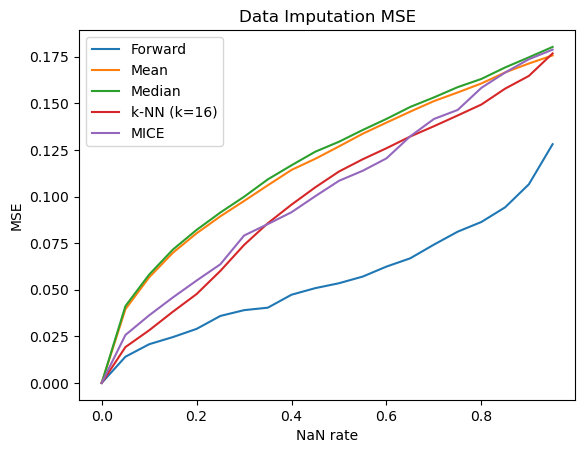

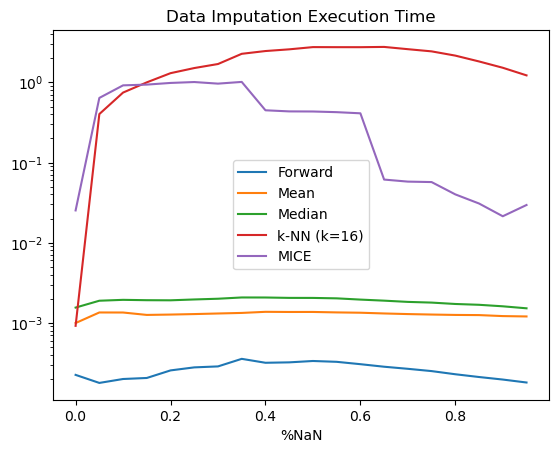

In [38]:
imputation_techniques = [
    (imputation_fedfroward, "Forward"),
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(16), "k-NN (k=16)"),
    (imputation_mice, "MICE")
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

<AxesSubplot:xlabel='NaN rate', ylabel='MSE'>

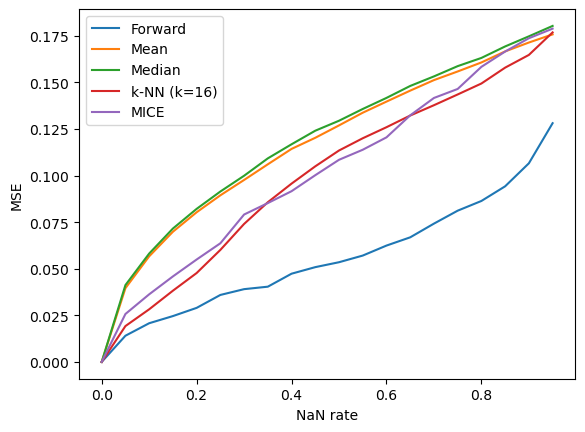

In [44]:
mse_statistic.plot( ylabel = "MSE",
                    xlabel = "NaN rate",
                )


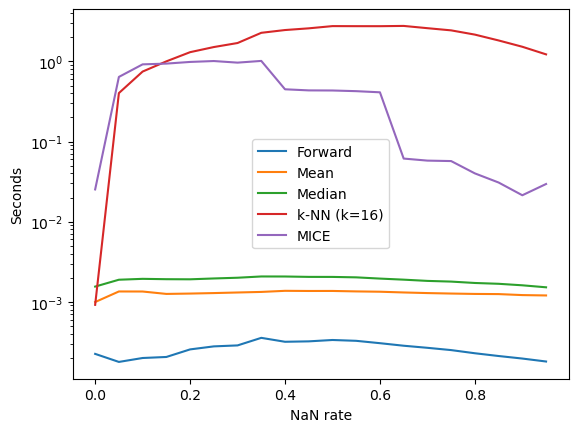

In [45]:
time_statistic.plot()
plt.yscale('log')
plt.xlabel("NaN rate")
plt.ylabel("Seconds")
plt.show()

# RESULT:
- k-NN and MICE increase the precision of the imputation
- The MSE of k-NN is about the half the mean-MSE.
- Performance of mean and median is almost the same, mean is slightly better on high % of NaN.
- Since mean and median are significantly faster than k-NN and MICE, we will use mean!


# Questions /TODOs
- Should I also test it on bigger datasets?
- It seems like the MSE is tiny for all methods. Is this the correct interpretation?
- The data is normalized to 0-1. A MSE of 0.1 means that the imputed values in average differ by 10% of the true value. Is this correct?

In [30]:
print("done")

done
